# Bayesian Beta Distributed Coin Inference

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://pyagrum.gitlab.io) |[ ![interactive online version](images/atbinder.svg)](https://mybinder.org/v2/gl/agrumery%2FaGrUM/forBinder?urlpath=%2Fdoc%2Ftree%2Fwrappers%2Fpyagrum%2Fdoc%2Fsphinx%2Fnotebooks%2F16-Examples_BayesianBetaCoin.ipynb)

## build a fully bayesian beta distributed coin inference

This notebook is based on examples from [Benjamin Datko](https://gist.github.com/bdatko).

The basic idea of this notebook is to show you could assess the probability for a coin, knowing a sequence of heads/tails.

In [1]:
import time

from pylab import *
import scipy.stats

import pyagrum as gum
import pyagrum.lib.notebook as gnb

In [2]:
gum.config["notebook", "default_graph_size"] = "12!"
gum.config["notebook", "default_graph_inference_size"] = "12!"

## Fill Beta parameters with a re-parameterization
* https://en.wikipedia.org/wiki/Beta_distribution

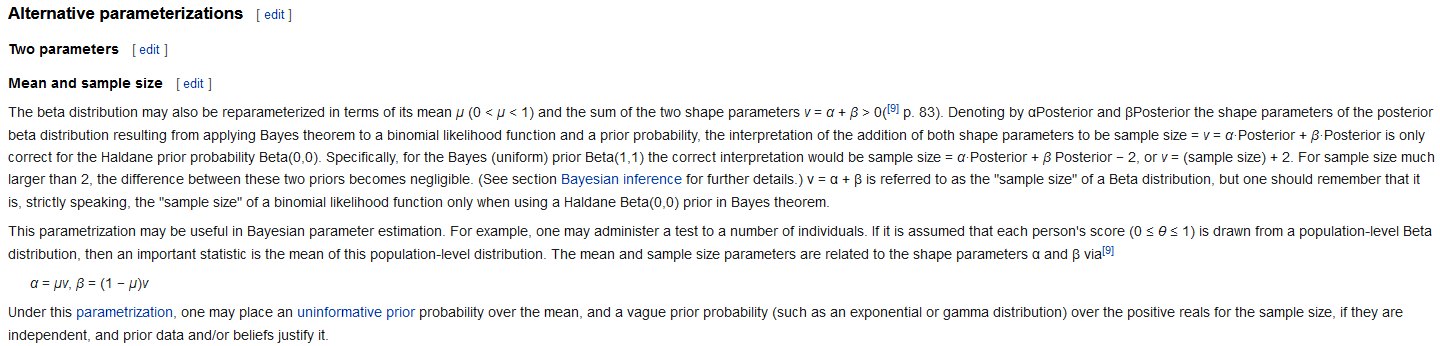

We propose a model where : mu and nu are the parameters of a beta which gives the distribution for the coins.

* below are some useful definitions
$$ \alpha = \mu \nu$$
$$ \beta = (1 - \mu) \nu $$

$$ \mu = \frac{\alpha}{\alpha + \beta} $$

* like in Wikipedia article, we will have a uniform prior on μ and an expoential prior on ν

In [3]:
# the sequence of COINS
serie = [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1]

In [4]:
NB_ = 200

vmin, vmax = 0.001, 0.999
pmin_mu, pmax_mu = 0.001, 0.999
pmin_nu, pmax_nu = 1, 50
size_ = 16

In [5]:
bn = gum.BayesNet("SEQUENCE OF COINS MODEL")
mu = bn.add(gum.NumericalDiscreteVariable("mu", "mean of the Beta distribution", pmin_mu, pmax_mu, NB_))
nu = bn.add(
  gum.NumericalDiscreteVariable("nu", "'sample size' of the Beta where nu = a + b > 0", pmin_nu, pmax_nu, NB_)
)
bias = bn.add(gum.NumericalDiscreteVariable("bias", "The bias of the coin", vmin, vmax, NB_))
hs = [bn.add(gum.RangeVariable(f"H{i}", "The hallucinations of coin flips", 0, 1)) for i in range(size_)]

bn.addArc(mu, bias)
bn.addArc(nu, bias)
for h in hs:
  bn.addArc(bias, h)
print(bn)
bn

BN{nodes: 19, arcs: 18, domainSize: 10^11.7196, dim: 7963598, mem: 61Mo 89Ko 128o}


(pyagrum.BayesNet@0x890e05e00) BN{nodes: 19, arcs: 18, domainSize: 10^11.7196, dim: 7963598, mem: 61Mo 89Ko 128o}


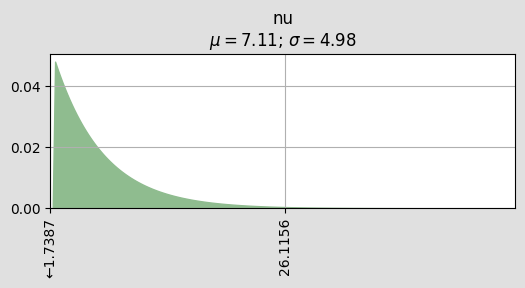
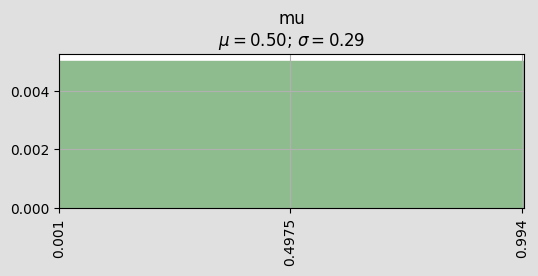

In [6]:
bn.cpt(nu).fillFromDistribution(scipy.stats.expon, loc=2, scale=5)
bn.cpt(mu).fillFromDistribution(scipy.stats.uniform, loc=pmin_mu, scale=pmax_mu - pmin_mu)

gnb.flow.clear()
gnb.flow.add(gnb.getProba(bn.cpt(nu)), caption="Distribution for nu")
gnb.flow.add(gnb.getProba(bn.cpt(mu)), caption="Distribution for mu")
gnb.flow.display()

In [7]:
# https://scicomp.stackexchange.com/a/10800
t_start = time.time()
bn.cpt("bias").fillFromDistribution(scipy.stats.beta, a="mu*nu", b="(1-mu)*nu")
end_time = time.time() - t_start
print(f"Filling {NB_}^3 parameters in {end_time:5.3f}s")

Filling 200^3 parameters in 2.640s


In [8]:
for h in hs:
  bn.cpt(h).fillFromDistribution(scipy.stats.bernoulli, p="bias")

## Evidence without evidence

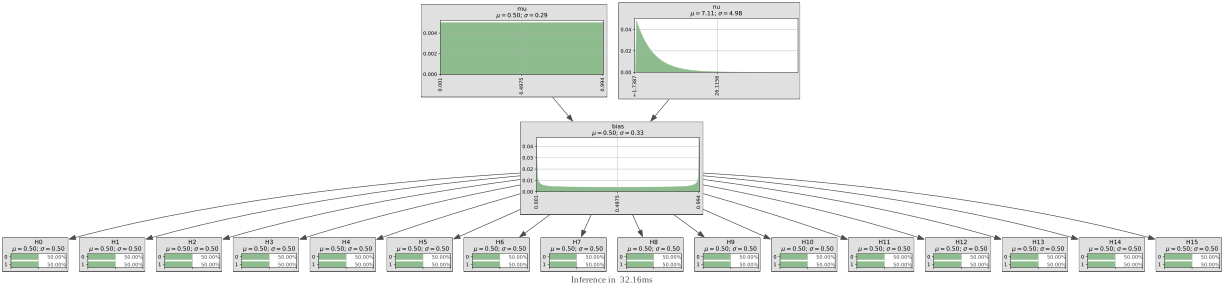

In [9]:
gnb.showInference(bn, size="17!")

In [10]:
print(bn)

BN{nodes: 19, arcs: 18, domainSize: 10^11.7196, dim: 7963598, mem: 61Mo 89Ko 128o}


## Evidence with the sequence 

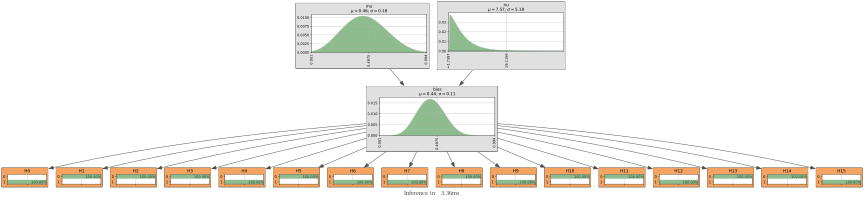

In [11]:
coin_evidence = {f"H{i}": serie[i] for i in range(len(serie))}

gnb.showInference(bn, evs=coin_evidence)

In [12]:
ie = gum.LazyPropagation(bn)
ie.setEvidence(coin_evidence)
ie.makeInference()

In [13]:
from scipy.ndimage import center_of_mass

idx = ie.posterior("bias").argmax()[0][0]["bias"]
map_bias = bn["bias"].label(idx)

com = center_of_mass(ie.posterior("nu").toarray())[0]

idx = ie.posterior("mu").argmax()[0][0]["mu"]
map_mu = bn["mu"].label(idx)


print(f"MAP for mu : {map_mu}")
print(f"center of mass for nu : {com}")
print(f"MAP for bias : {map_bias}")

MAP for mu : 0.4473
center of mass for nu : 26.67889867211198
MAP for bias : 0.4373


## Smaller serie

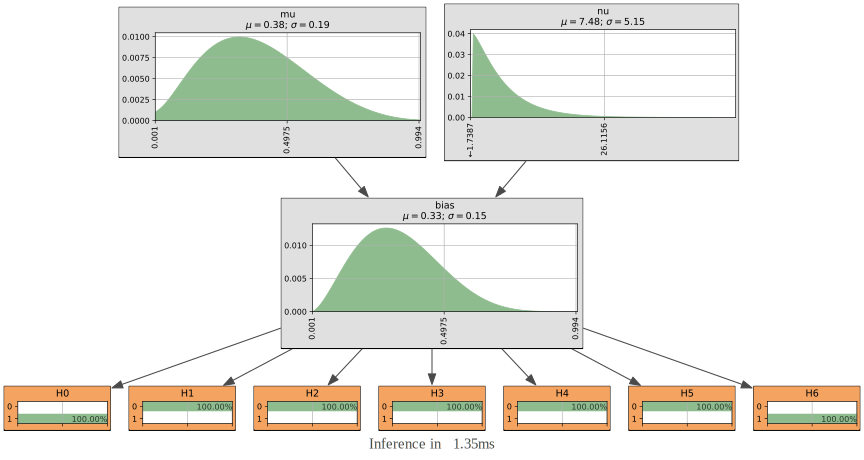

In [14]:
# With a smaller serie
serie = [
  1,
  0,
  0,
  0,
  0,
  0,
  1,
]

bn = gum.BayesNet("SEQUENCE OF COINS MODEL")
mu = bn.add(gum.NumericalDiscreteVariable("mu", "mean of the Beta distribution", pmin_mu, pmax_mu, NB_))
nu = bn.add(
  gum.NumericalDiscreteVariable("nu", "'sample size' of the Beta where nu = a + b > 0", pmin_nu, pmax_nu, NB_)
)
bias = bn.add(gum.NumericalDiscreteVariable("bias", "The bias of the coin", vmin, vmax, NB_))
hs = [bn.add(gum.RangeVariable(f"H{i}", "The hallucinations of coin flips", 0, 1)) for i in range(len(serie))]

bn.addArc(mu, bias)
bn.addArc(nu, bias)
for h in hs:
  bn.addArc(bias, h)

bn.cpt(nu).fillFromDistribution(scipy.stats.expon, loc=2, scale=5)
bn.cpt(mu).fillFromDistribution(scipy.stats.uniform, loc=pmin_mu, scale=pmax_mu - pmin_mu)

bn.cpt("bias").fillFromDistribution(scipy.stats.beta, a="mu*nu", b="(1-mu)*nu")

for h in hs:
  bn.cpt(h).fillFromDistribution(scipy.stats.bernoulli, p="bias")

coin_evidence = {f"H{i}": serie[i] for i in range(len(serie))}

gnb.showInference(bn, evs=coin_evidence)